In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import pandas as pd
import sys
from tqdm import tqdm
sys.path.append('../Deep_Learning/')
from nn_optimization_methods import SGD
from layers.Dense import Dense
from layers.Input import Input
sys.path.append('../tools/')
import tools

%matplotlib inline

# DeepNeuralNetwork 

## Regression

### approximate sin function from random values.

In [2]:
x = np.linspace(-1, 1, 1000)

In [3]:
y = np.sin(x)**2

In [4]:
df = pd.DataFrame({'x':x,'y':y})

In [4]:
class DNN():
    
    """
    Deep Neural Network Template for regression and classification tasks
    Parameters:
        X: numpy array() data matrix
        y: numpy array() response variables, must be numeric
        output: numpy array() outputs
        outlayer = output layer
        head = input layer
    
    Use like sequential model from Keras:
        Ex: add a dense layer with 200 neurons and a sigmoid activation function:
                dnn.add("dense","sigmoid",200)
    """
    def __init__(self,X,y):
            
        self.X = X
        self.y = y
        self.output = 0
        self.outlayer = Input(self.X)
        self.head = self.outlayer
    
    def add(self,layertype,activation,neurons):
        
        if layertype == "dense":
                layer = Dense(self.outlayer,neurons,activation)
                self.outlayer.setNext(layer)
                self.outlayer = layer
            
    def foward(self,inputs=None):
        
        if np.all(inputs != None):
            
            self.head.update(inputs)
            
        layer = self.head
        
        while np.all(layer.next != None):
            
            layer.foward()
            layer = layer.getNext()
        
        layer.foward()
        return layer.output
        
    def backward_pass(self,predictions,y,loss="MSE"):
        
        cache = 0
        gradients = []
        
        if loss == "MSE":
            
            layer = self.outlayer
            cache = np.array(np.sum(predictions - y))
            w_derivative = layer.getPrev().dot(cache*(layer.deriv),True)
            b_derivative = cache*(layer.deriv)
            gradients.append([w_derivative,b_derivative])
            layer = layer.getPrev()
            while np.all(layer.getPrev() != None):
                cache = (cache.dot(layer.getNext().getWeights()[0].T))*layer.deriv
                w_derivative = layer.getPrev().dot(cache,True)
                b_derivative = cache
                gradients.append([w_derivative,b_derivative])
                layer = layer.getPrev()
            
            return gradients[::-1]
        
    def train(self,X,y,optimizer=SGD,lr=0.0001,epochs=100,batch_size=1):
        
        optimizer(self,X,y,learning_rate=lr,epochs=epochs,batch_size=batch_size)
        
    def predict(self,X):
        
        return self.foward(X)
        
    def __str__(self):
        
        string = "----------------------------- Model -----------------------------" + '\n'
        layer = self.head
        
        while np.all(layer != None):
            string += layer.__str__()
            layer = layer.getNext()
            
        return string
    

In [6]:
x = x.reshape(x.shape[0],1)
dnn = DNN(x,y)
dnn.add("dense","sigmoid",24)
dnn.add("dense","sigmoid",48)
dnn.add("dense","sigmoid",16)
dnn.add("dense","linear",1)
print(dnn)

----------------------------- Model -----------------------------
Input: shape: (None, 1)
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (1, 24), output shape: (None, 24), parameters: 24
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (24, 48), output shape: (None, 48), parameters: 1152
-----------------------------------------------------------------
Dense: activation: sigmoid, weight shape: (48, 16), output shape: (None, 16), parameters: 768
-----------------------------------------------------------------
Dense: activation: linear, weight shape: (16, 1), output shape: (None, 1), parameters: 16
-----------------------------------------------------------------



In [7]:
dnn.train(x,y,lr=0.001,epochs=1000)

MSE 2.524175384541316e-05: 100%|██████████| 1000/1000 [11:52<00:00,  1.40it/s]


In [8]:
predictions = dnn.predict(x)

In [9]:
predictions = predictions.reshape(predictions.shape[0],)

In [10]:
newd = pd.DataFrame({'x':df["x"],'y':predictions})

In [11]:
df["y"][:20]

0     0.708073
1     0.706251
2     0.704426
3     0.702597
4     0.700765
5     0.698930
6     0.697092
7     0.695250
8     0.693406
9     0.691558
10    0.689707
11    0.687854
12    0.685997
13    0.684137
14    0.682274
15    0.680408
16    0.678540
17    0.676668
18    0.674794
19    0.672917
Name: y, dtype: float64

In [12]:
newd["y"][:20]

0     0.697488
1     0.695706
2     0.693922
3     0.692136
4     0.690349
5     0.688559
6     0.686768
7     0.684975
8     0.683180
9     0.681383
10    0.679585
11    0.677784
12    0.675982
13    0.674178
14    0.672372
15    0.670565
16    0.668755
17    0.666944
18    0.665132
19    0.663317
Name: y, dtype: float64

Predicted after 1000 epochs

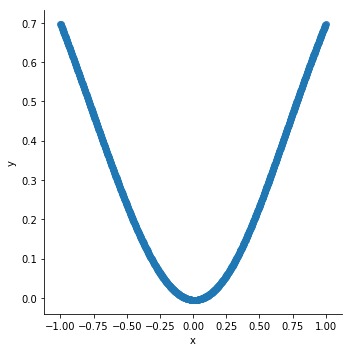

In [13]:
sns.lmplot(x='x', y='y',data=newd,
           fit_reg=False, # No regression line
          )  

Original sin wave

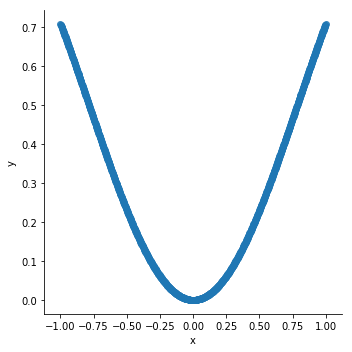

In [14]:
sns.lmplot(x='x', y='y',data=df,
           fit_reg=False, # No regression line
          )   

## Classification

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
indices = np.arange(y.shape[0])
np.random.shuffle(indices)

In [6]:
X = X[indices]
y = y[indices]
X_train, X_test, y_train, y_test = tools.cross_val_split_set(X,0.1,y)
ones = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1).astype(float)
X_train = np.column_stack((ones,X_train))
ones = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)
X_test = np.column_stack((ones,X_test))